In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

linelist_deaths = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/linelist/linelist_deaths.csv'
vax_agg = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/vaccination/vax_malaysia.csv'

date_min = date(2021,5,24) # Phase 2 vax started 19 Apr; 2nd dose on 10 May; fully vax on 24 May
date_max = date.today() - timedelta(8) # most recent 7 days incomplete
data_range = 'data from ' + date_min.strftime('%d-%b') + ' to ' + date_max.strftime('%d-%b')
total_adults = 23966637 # same as other notebooks

In [2]:
def vaxStatus(date_pos, date1, date2, date3):
    if (date_pos - date3).days > 6: return 'boosted'
    elif (date_pos - date2).days > 13: return 'fullyvax'
    elif (date_pos - date1).days >= 0: return 'partialvax'
    else: return 'unvax'
    

# Pull latest deaths linelist and wrangle
cols_date = ['date', 'date_positive', 'date_dose1', 'date_dose2', 'date_dose3']
df = pd.read_csv(linelist_deaths,
                 usecols=cols_date + ['brand1','age'])
for c in cols_date: df[c] = pd.to_datetime(df[c],errors='coerce').dt.date
df = df[(df.date >= date_min) & (df.date <= date_max)]
df = df[df.age > 17] # adults only
df.drop(['age'],axis=1,inplace=True)

# Ensure no null vax dates (future date as placeholder), shift 14 days for Cansino, then encode vax status
for c in ['date_dose1', 'date_dose2', 'date_dose3']: df[c] = df[c].fillna(date.today() + timedelta(1))
df.loc[df.brand1.isin(['Cansino']), 'date_dose2'] = df.date_dose1 + timedelta(14)
df['status'] = df.apply(lambda x: vaxStatus(x['date_positive'], x['date_dose1'], x['date_dose2'], x['date_dose3']), axis=1)
df = df.replace(date.today() + timedelta(1), np.nan)  # Remove placeholder dates
df['deaths'] = 1

df.date = pd.to_datetime(df.date)
df = df.groupby(['date', 'status']).sum() \
                .unstack(fill_value=0) \
                .asfreq('D',fill_value=0) \
                .stack() \
                .reset_index() # Typically, unstack/stack suffices, but this is robust to having dates with no deaths
df.date = df.date.dt.date
df = df[~df.status.isin(['partialvax'])].reset_index(drop=True)
df[-18:].head(18)

,date,status,deaths
864,2022-03-08,boosted,14
865,2022-03-08,fullyvax,37
866,2022-03-08,unvax,22
867,2022-03-09,boosted,20
868,2022-03-09,fullyvax,33
869,2022-03-09,unvax,33
870,2022-03-10,boosted,21
871,2022-03-10,fullyvax,39
872,2022-03-10,unvax,18
873,2022-03-11,boosted,13


In [3]:
shifts = {'cumul_partial_adult': 1, 'cumul_full_adult': 14, 'cumul_booster':7}

vf = pd.read_csv(vax_agg)
vf.date = pd.to_datetime(vf.date).dt.date
vf['cumul_partial_adult'] = vf.cumul_partial - vf.cumul_partial_adol - vf.cumul_partial_child
vf['unvax_adult'] = total_adults - vf.cumul_partial_adult
vf['cumul_full_adult'] = vf.cumul_full - vf.cumul_full_adol - vf.cumul_full_child - vf.cumul_booster
vf['cumul_partial_adult'] = vf['cumul_partial_adult'] - vf['cumul_full_adult'] - vf.cumul_booster

for c in ['cumul_partial_adult', 'cumul_full_adult','cumul_booster']: vf[c] = vf[c].shift(shifts[c]).fillna(0).astype(int)
vf = vf[['date','unvax_adult','cumul_partial_adult','cumul_full_adult','cumul_booster']]
col_status = ['unvax','partialvax','fullyvax','boosted']
vf.columns = ['date'] + col_status
vf = pd.melt(vf, id_vars=['date'], value_vars=col_status)
vf.columns = ['date','status','population']
vf = vf[(vf.date >= date_min) & (vf.date <= date_max)]
vf = vf[~vf.status.isin(['partialvax'])].sort_values(by=['date','status']).reset_index(drop=True)
vf[-18:].head(18)

,date,status,population
864,2022-03-08,boosted,14759732
865,2022-03-08,fullyvax,8719041
866,2022-03-08,unvax,758016
867,2022-03-09,boosted,14830764
868,2022-03-09,fullyvax,8622531
869,2022-03-09,unvax,757120
870,2022-03-10,boosted,14903527
871,2022-03-10,fullyvax,8532850
872,2022-03-10,unvax,756138
873,2022-03-11,boosted,14961911


In [4]:
# Merge frames and compute incidence, then get 7d rolling average
df = pd.merge(df,vf, on=['date','status'], how='left')
df['capita'] = df.deaths/df.population * 1e5
df = df.pivot(index='date', columns='status', values=['capita']).fillna(0).reset_index()
df.columns = ['date','Boosted','Fully Vaccinated','Unvaccinated']
df = df[['date','Unvaccinated','Fully Vaccinated','Boosted']].set_index('date')
df = df.rolling(7).mean().reset_index()
df[-14:].head(14)

,date,Unvaccinated,Fully Vaccinated,Boosted
280,2022-02-28,2.307568,0.307772,0.062841
281,2022-03-01,2.421783,0.333374,0.065501
282,2022-03-02,2.462875,0.359101,0.068012
283,2022-03-03,2.652645,0.372656,0.069723
284,2022-03-04,2.804413,0.384604,0.078474
285,2022-03-05,2.658209,0.400370,0.087923
286,2022-03-06,2.810629,0.412241,0.086334
287,2022-03-07,2.963779,0.414528,0.092703
288,2022-03-08,3.023170,0.402202,0.096195
289,2022-03-09,3.159202,0.401465,0.102472


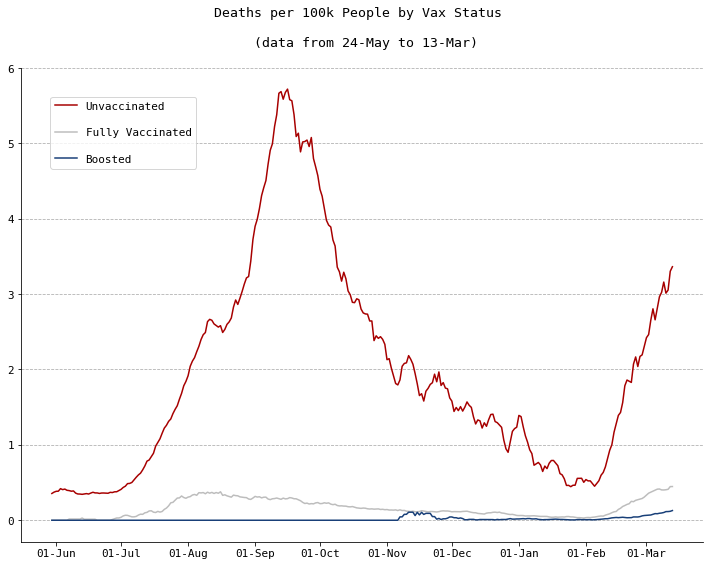

In [5]:
# Chart
plt.rcParams.update({'font.size': 11, 'font.family':'Monospace', 'grid.linestyle':'dashed'})
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

df.plot(x='date', y=['Unvaccinated','Fully Vaccinated','Boosted'], color=['#a70000','#bdbdbd','#183f78'], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.legend(loc='upper center', bbox_to_anchor=(0.15, 0.95), ncol=1, labelspacing = 1.5, frameon=True, fancybox=True)

plt.title('Deaths per 100k People by Vax Status \n\n (' + data_range + ')\n')
plt.xlabel('')
plt.ylabel('')
plt.show()